In [17]:
import math
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from osgeo import gdal, ogr, osr
import numpy as np
import os
import pandas as pd

In [39]:
#work flow

# this function will be used for constraint mapping the class map .the raw shape file should be used as input . after using the  function . the output raster file should be clipped by study area or boundary box.
#clipping function by two methods are porvided in another script (aslo given in this notebook)


In [16]:
#access the google drive file
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
study_map=ogr.Open(f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp')
layer =study_map.GetLayer()
extent = layer.GetExtent()
xmin =extent[0]
xmax =extent[1]
ymin =extent[2]
ymax =extent[3]

#  Constraint Mapping Function for Calss Map

In [21]:
#shape_file-input shape file .check it should be a polygon shape file                                                     #given by user
#keep_values -it should be a array . the categorial values that the user want to keep                                     #given by user
#inter_shape_file-intermediate shape file location that is created in the function for calculation purpose
#output_raster - final raster file location
#pixel -target pixel size                                                                                                 #given by user
#col - the class or categorial value column name (header ofthe attribute table where this categorical value presents)     #given by user


def constraint_mapping(shape_file,col,keep_values,inter_shape_file,output_raster,pixel):

  data=gpd.read_file(shape_file)
  no_of_unique=data[col].nunique()
  unique_data=data[col].unique()
  so_c=data.copy()

  d={}

  for soil in unique_data:
    if soil in keep_values:
      d[soil]=1
    else:
      d[soil]=0

  so_c[col]=so_c[col].replace(d).astype('int')

  gdf = gpd.GeoDataFrame(so_c,geometry=so_c['geometry'])

  gdf.to_file(inter_shape_file)

  output_raster_location =output_raster
  pixel_size =pixel

  sh=ogr.Open(inter_shape_file)
  source_layer=sh.GetLayer()
  xmin, xmax, ymin, ymax = source_layer.GetExtent()
  x_res =int((xmax - xmin) / pixel_size)
  y_res =int((ymax - ymin) / pixel_size)

  target_ds = gdal.GetDriverByName('GTiff').Create(output_raster_location, x_res, y_res, 1,gdal.GDT_Float32,['COMPRESS=LZW'])

  target_ds.SetGeoTransform((xmin, pixel_size, 0.0, ymax, 0.0,-pixel_size))
  srse = osr.SpatialReference()
  proj ='EPSG:4326'

  srse.SetWellKnownGeogCS(proj)

  target_ds.SetProjection(srse.ExportToWkt())
  band = target_ds.GetRasterBand(1)

  target_ds.GetRasterBand(1).SetNoDataValue(np.nan)

  band.Fill(np.nan)




  gdal.RasterizeLayer(target_ds,[1],source_layer, None, None,[1],options =['ALL_TOUCHED=TRUE', f'ATTRIBUTE={col}'])
  target_ds = None


In [22]:
shape_file=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/Land Cover and vegetation/soil data FAO/soil_shape_clip.shp'
col='DOMSOI'
keep_values=keep_values=['Bh','Bk','Bg','Wd','Zg','Vc']
inter_shape_file=f'/content/drive/MyDrive/constraint mapping/soil_cons_map.shp'
output_raster=f'/content/drive/MyDrive/constraint mapping/soil_cons_map.tif'
pixel=0.004

In [23]:
constraint_mapping(shape_file,col,keep_values,inter_shape_file,output_raster,pixel)

<ipython-input-21-2087476776a3>:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  so_c[col]=so_c[col].replace(d).astype('int')


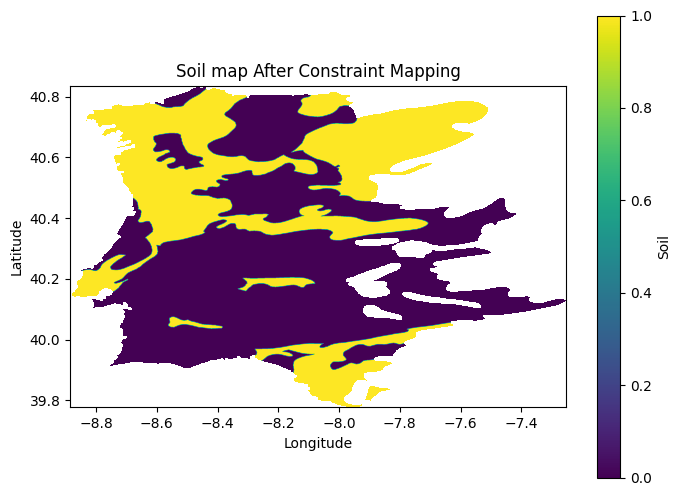

In [26]:
#visualize output
raster=gdal.Open(f'/content/drive/MyDrive/constraint mapping/soil_cons_map.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray(),extent=(xmin, xmax, ymin, ymax), origin='upper',cmap='viridis')
plt.colorbar(label='Soil')
plt.title('Soil map After Constraint Mapping')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

# Test clipping

In [27]:
pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 65.5 MB/s eta 0:00:00


In [28]:
pip install fiona

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 19.8 MB/s eta 0:00:00


# Clip by Study Area Function

In [29]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np


#function parameters

#raster_path-input raster file path            (given by user)
#shapefile_path-study area path                (given by user)
#output_path-output raster file path
#target_pixel_size-output raster pixel size    (given by user)



def clip_and_adjust_pixel_size(raster_path, shapefile_path, output_path, target_pixel_size):
    """
    Clip a raster file using a shapefile and adjust the pixel size to a specified value.

    Parameters:
    - raster_path: Path to the input raster file.
    - shapefile_path: Path to the shapefile used for clipping.
    - output_path: Path to the output clipped and adjusted raster file.
    - target_pixel_size: The desired pixel size for the output raster.
    """
    with rasterio.open(raster_path) as src:
        # Read the shapefile geometries
        gdf = gpd.read_file(shapefile_path)
        shapes = gdf.geometry

        # Get the bounding box of the shapefile
        shapefile_bounds = shapes.total_bounds
        left, bottom, right, top = shapefile_bounds

        # Calculate the new width and height based on the bounding box and the target pixel size
        new_width = int((right - left) / target_pixel_size)
        new_height = int((top - bottom) / target_pixel_size)

        # Calculate the new transform
        new_transform = rasterio.transform.from_origin(left, top, target_pixel_size, target_pixel_size)

        # Create an empty destination array to hold the resampled data
        destination = np.full((src.count, new_height, new_width), np.nan, dtype='float32')

        # First, reproject the entire raster to the new resolution
        for i in range(src.count):
            reproject(
                source=rasterio.band(src, i + 1),
                destination=destination[i],
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=new_transform,
                dst_crs=src.crs,
                resampling=Resampling.bilinear
            )

        # Create mask from shapefile
        mask_array = rasterio.features.rasterize(
            shapes,
            out_shape=(new_height, new_width),
            transform=new_transform,
            fill=0,
            all_touched=True,
            default_value=1,
            dtype='uint8'
        )

        # Apply mask
        for i in range(src.count):
            destination[i][mask_array == 0] = np.nan

        # Update the metadata
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": new_height,
            "width": new_width,
            "transform": new_transform,
            "dtype": 'float32',  # Ensure the output is in a floating-point type
            "nodata": np.nan
        })

        # Write the resampled and masked raster to the output file
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(destination)

In [31]:
raster_file=f'/content/drive/MyDrive/constraint mapping/soil_cons_map.tif'
shapefile=f'/content/drive/MyDrive/Portugal ALL/task 3.5 self/flood/wise_vw_surfacewaterbody_basin_Mondego_Contorno.shp'
pixel_size=0.004
output_file=f'/content/drive/MyDrive/constraint mapping/soil_cons_map_clip_by_study_area.tif'

In [32]:
clip_and_adjust_pixel_size(raster_file, shapefile,output_file,pixel_size)

In [44]:
raster=gdal.Open(f'/content/drive/MyDrive/constraint mapping/soil_cons_map_clip_by_study_area.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size
ar1=raster.GetRasterBand(1).ReadAsArray()
print("Information of Soil Contraint Mapping file by  Study Area:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of Soil Contraint Mapping file by  Study Area:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


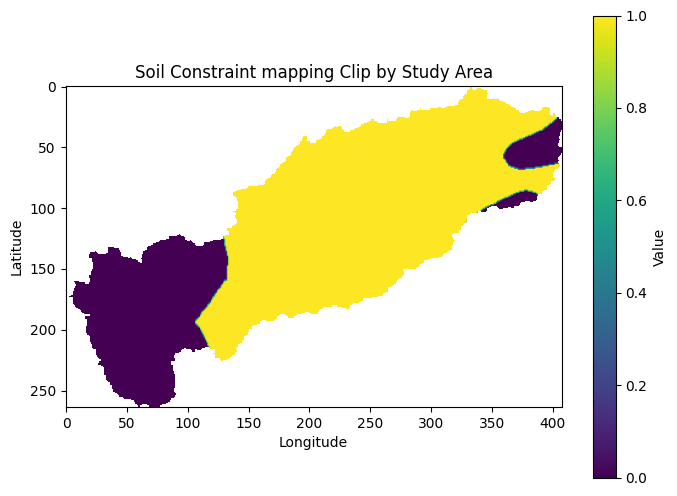

In [38]:
raster=gdal.Open(f'/content/drive/MyDrive/constraint mapping/soil_cons_map_clip_by_study_area.tif')
plt.figure(figsize=(8,6))
arr=raster.GetRasterBand(1).ReadAsArray()
plt.imshow(arr, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Soil Constraint mapping Clip by Study Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [36]:
max=arr[~np.isnan(arr)].max()
max

1.0

In [37]:
min=arr[~np.isnan(arr)].min()
min

0.0

# clip by Boundary box

In [40]:
#this function takes  input raster file that we want to clip, bounding box(xmin,xmax,ymin,ymax) and the pixel size as arguments
#rasterfile-input raster file (given by user)
#xmin,xamx,ymin,ymax- bounding box( given by user)
#res-pixel size of output raster (given by user)
#output file-final clipped raster location


def clip_raster_gdal(raster_file, xmin, xmax, ymin, ymax,res,output_file):
    """


    Args:
        raster_file: Path to the input raster file.
        xmin: Minimum x-coordinate of the bounding box.
        xmax: Maximum x-coordinate of the bounding box.
        ymin: Minimum y-coordinate of the bounding box.
        ymax: Maximum y-coordinate of the bounding box.
        output_file: Path to the output clipped raster file.
    """

    # Open the input raster file
    ds = gdal.Open(raster_file)

    # Get the raster's coordinate system
    srs = ds.GetProjection()

    # Create a new GeoTransform for the clipped raster
    gt = ds.GetGeoTransform()
    new_gt =(xmin,res,0,ymax,0,-res)

    # Create a new dataset for the clipped raster
    out_ds = gdal.GetDriverByName('GTiff').Create(
        output_file,
        int((xmax - xmin) /res),
        int((ymax - ymin) /res),
        1,   #ds.GetRasterCount()
        gdal.GDT_Float32
    )

    # Set the coordinate system and geotransform for the output dataset
    out_ds.SetProjection(srs)
    out_ds.SetGeoTransform(new_gt)

    # Copy the raster data from the input dataset to the output dataset
    gdal.Warp(out_ds,ds,cropToCutline=True,dstSRS=srs, dstNodata=np.nan)

    # Close the datasets
    ds = None
    out_ds = None

In [45]:
#clipping constarint map
raster_file=f'/content/drive/MyDrive/constraint mapping/soil_cons_map.tif'
output_file =f'/content/drive/MyDrive/constraint mapping/soil_cons_map_clip_by_bounding_box.tif'
clip_raster_gdal(raster_file, xmin, xmax, ymin, ymax,0.004,output_file)

In [46]:
raster=gdal.Open(f'/content/drive/MyDrive/constraint mapping/soil_cons_map_clip_by_bounding_box.tif')
gt=raster.GetGeoTransform()
array_size=raster.GetRasterBand(1).ReadAsArray().size

print("Information of Soil Constraint Mapping By Bounding Box file:")
print(f"upper left x point: {gt[0]}")
print(f"x pixel: {gt[1]}")
print(f"upper left x point: {gt[3]}")
print(f"y pixelt: {gt[5]}")
print(f"Array Size: {array_size}")
print(f"Raster X size :{raster.RasterXSize}")
print(f"Raster Y size :{raster.RasterYSize}")

Information of Soil Constraint Mapping By Bounding Box file:
upper left x point: -8.885562971952766
x pixel: 0.004
upper left x point: 40.83664625592087
y pixelt: -0.004
Array Size: 107712
Raster X size :408
Raster Y size :264


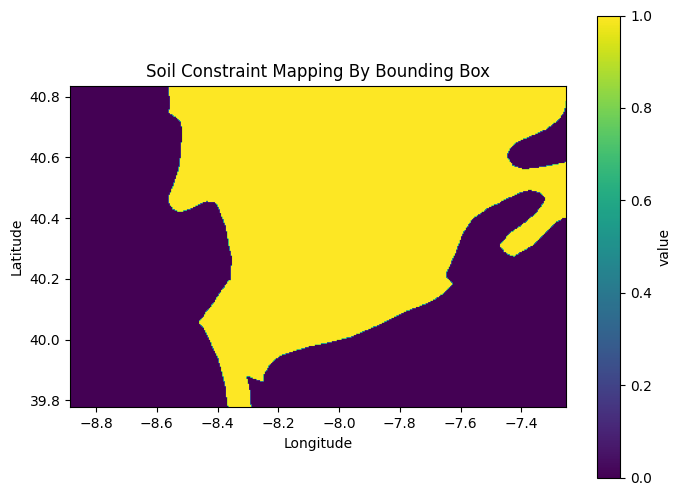

In [47]:
raster=gdal.Open(f'/content/drive/MyDrive/constraint mapping/soil_cons_map_clip_by_bounding_box.tif')
plt.figure(figsize=(8,6))
plt.imshow(raster.GetRasterBand(1).ReadAsArray(),extent=(xmin, xmax, ymin, ymax), origin='upper', cmap='viridis')
plt.colorbar(label='value')
plt.title('Soil Constraint Mapping By Bounding Box')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [48]:
raster=gdal.Open(f'/content/drive/MyDrive/constraint mapping/soil_cons_map_clip_by_bounding_box.tif')
ar=raster.GetRasterBand(1).ReadAsArray()

In [51]:
max=arr[~np.isnan(arr)].max()
max

1.0

In [52]:
min=arr[~np.isnan(arr)].min()
min

0.0